In [12]:
# Load the wine data from chapter 4, and create a new model with the appropriate number of input parameters
import csv
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from collections import OrderedDict

In [13]:
wine_path="./winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1)
wineq_numpy, wineq_numpy.shape

(array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
        [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
        [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
        ...,
        [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
        [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
        [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32),
 (4898, 12))

In [14]:
col_list = next(csv.reader(open(wine_path))) #next item from the iterator
num_row = wineq_numpy.shape[0]
num_col = wineq_numpy.shape[1]
attrs = torch.tensor(np.array(wineq_numpy[:,0:11]))
ans = torch.tensor(np.array(wineq_numpy[:,11]))
attrs, ans

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 tensor([6., 6., 6.,  ..., 6., 7., 6.]))

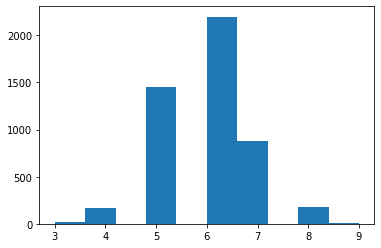

In [15]:
plt.hist(np.array(wineq_numpy[:,11],dtype=int))
plt.show()

In [16]:
def shuffle_and_devide_set(t_u: torch, t_c:torch, ratio):
    n_samples = t_u.shape[0]
    n_val = int(ratio*n_samples)

    shuffled_indices = torch.randperm(n_samples)

    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    train_indices, val_indices
    train_t_u = t_u[train_indices]
    train_t_c = t_c [train_indices]

    val_t_u = t_u[val_indices]
    val_t_c = t_c [val_indices]

    return train_t_u, train_t_c, val_t_u, val_t_c

In [17]:
col_norm1 = [True,False,False,True,False,False,False,True,True,False,True]
col_norm2 = [False,False,False,False,False,True,True,False,False,False,False]
attrs_n = attrs.clone()
attrs_n[:,col_norm1] *= 0.1
attrs_n[:,col_norm2] *= 0.01
ans_n = ans*0.1-0.5
attr_t, ans_t, attr_v, ans_v = shuffle_and_devide_set(attrs_n, ans_n, 0.2)
ans_t = ans_t.unsqueeze(1);
ans_v = ans_v.unsqueeze(1);

print(attr_t.shape, attr_v.shape)
print(ans_t.shape, ans_v.shape)
print(attrs.mean(dim=0))
print( attrs_n.mean(dim=0))
print(ans_v)


torch.Size([3919, 11]) torch.Size([979, 11])
torch.Size([3919, 1]) torch.Size([979, 1])
tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])
tensor([0.6855, 0.2782, 0.3342, 0.6391, 0.0458, 0.3531, 1.3836, 0.0994, 0.3188,
        0.4898, 1.0514])
tensor([[ 0.1000],
        [ 0.0000],
        [ 0.1000],
        [ 0.1000],
        [ 0.0000],
        [ 0.2000],
        [ 0.2000],
        [ 0.2000],
        [ 0.0000],
        [ 0.1000],
        [ 0.0000],
        [ 0.1000],
        [ 0.2000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1000],
        [ 0.2000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.1000],
        [ 0.2000],
        [ 0.1000],
        [ 0.0000],
        [ 0.3000],
        [ 0.2000],
        [ 0.2000],
        [ 0.1000],
        [ 0.1000],
        [ 0.0000],
        [ 0.0000],
        [ 0.1000],
        [ 0.1000],
        [ 0.2000],
        [-0.

In [18]:
def compare_out_ans(output:torch, ans:torch) :
    r_out = torch.round(output.clone().detach().squeeze()*10)
    ans = torch.round(ans.clone().detach().squeeze()*10)
    right=0
    total=length = output.shape[0]
    for i in range(0,length):
        if(r_out[i] == ans[i]):
            right+=1
    return right, total
        


In [24]:
def training_loop(n_epochs:int, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train=loss_fn(t_p_train, t_c_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch %10 or epoch % 500 == 0:
            with torch.no_grad():
                t_p_val = model(t_u_val)
                loss_val = loss_fn(t_p_val, t_c_val)
                right, total = compare_out_ans(t_p_val, t_c_val) 
                print(f"Epoch {epoch:5d} Train Loss {loss_train.item():.4f} val loss {loss_val.item():.4f}",
                f"    score: {right:3d} / {total:3d} = {right/total*100:.2f}%")

In [26]:
model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11,11)),
    ('hidden_activation', nn.Tanh()),
    ('hidden_linear', nn.Linear(11,6)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(6,1))
       
]))
attr_t = attr_t.clone().detach().requires_grad_(True)
attr_v = attr_v.clone().detach().requires_grad_(True)
ans_t =  ans_t.clone().detach().requires_grad_(True)
ans_v =  ans_v.clone().detach().requires_grad_(True)

optimizer = optim.Adam(model.parameters(), lr =1e-3)
loss_fn = nn.MSELoss() 
training_loop(
    1000, optimizer, 
    model, loss_fn, 
    attr_t, attr_v,
    ans_t, ans_v
)



Epoch     1 Train Loss 0.0199 val loss 0.0175     score: 217 / 979 = 22.17%
Epoch     2 Train Loss 0.0175 val loss 0.0154     score: 248 / 979 = 25.33%
Epoch     3 Train Loss 0.0153 val loss 0.0135     score: 284 / 979 = 29.01%
Epoch     4 Train Loss 0.0135 val loss 0.0120     score: 306 / 979 = 31.26%
Epoch     5 Train Loss 0.0119 val loss 0.0107     score: 339 / 979 = 34.63%
Epoch     6 Train Loss 0.0106 val loss 0.0097     score: 373 / 979 = 38.10%
Epoch     7 Train Loss 0.0095 val loss 0.0089     score: 403 / 979 = 41.16%
Epoch     8 Train Loss 0.0087 val loss 0.0084     score: 403 / 979 = 41.16%
Epoch     9 Train Loss 0.0082 val loss 0.0081     score: 418 / 979 = 42.70%
Epoch    11 Train Loss 0.0076 val loss 0.0079     score: 430 / 979 = 43.92%
Epoch    12 Train Loss 0.0076 val loss 0.0080     score: 437 / 979 = 44.64%
Epoch    13 Train Loss 0.0077 val loss 0.0082     score: 432 / 979 = 44.13%
Epoch    14 Train Loss 0.0079 val loss 0.0084     score: 432 / 979 = 44.13%
Epoch    15 

(array([  3.,  30.,   0., 209.,   0., 496., 223.,   0.,  15.,   3.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

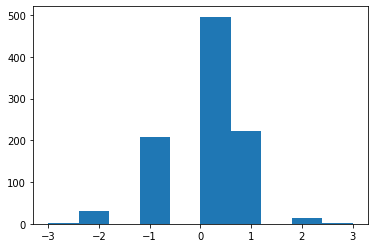

In [21]:
out = (model(attr_v)).detach().numpy()
ans_v_numpy = ans_v.detach().numpy()
ret = (out-ans_v_numpy)*10
ret =np.round(ret)
plt.hist(ret)

In [22]:
def rough_answer(out:np.ndarray, ans:np.ndarray):
    ret = np.round((out-ans)*10.0)
    total = out.shape[0]
    correct = ((np.abs(ret)<=1)).sum()
    return correct, total
rc, total = rough_answer(out, ans_v_numpy)
print(f"rough answer: {rc}/{total} = {rc/total*100.0:4f}%")
    

rough answer: 928/979 = 94.790603%
